In [1]:
library(tidyverse)
library(glmnet)
library(tidymodels)
library(mltools)
library(leaps)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1

In [66]:
tips <- read.csv("tips.csv",stringsAsFactors=TRUE)
#tips$size <- as.factor(tips$size)
head(tips)

,total_bill,tip,sex,smoker,day,time,size
,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4
6,25.29,4.71,Male,No,Sun,Dinner,4


In [67]:
tips |>
group_by(size) |>
summarise(numsize = n())

tips |>
group_by(day) |>
summarise(numsize = n())

size,numsize
<int>,<int>
1,4
2,156
3,38
4,37
5,5
6,4


day,numsize
<fct>,<int>
Fri,19
Sat,87
Sun,76
Thur,62


In [68]:
set.seed(1)
tips_ID <- tips |>
            mutate(ID = row_number())
tips_train <- tips_ID |>
              slice_sample(prop = 0.5)

tips_test <- tips_ID |>
             anti_join(tips_train, by = "ID")

tips_train <- select(tips_train, -ID)
tips_test <- select(tips_test


In [69]:
tips_forward_selection <- regsubsets(x = tip ~ total_bill + sex + smoker + day + size, nvmax = 8,
                                  data = tips_train,
                                  method = "forward")

tips_forward_summary <- summary(tips_forward_selection)
tips_forward_summary

Subset selection object
Call: regsubsets.formula(x = tip ~ total_bill + sex + smoker + day + 
    size, nvmax = 8, data = tips_train, method = "forward")
7 Variables  (and intercept)
           Forced in Forced out
total_bill     FALSE      FALSE
sexMale        FALSE      FALSE
smokerYes      FALSE      FALSE
daySat         FALSE      FALSE
daySun         FALSE      FALSE
dayThur        FALSE      FALSE
size           FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         total_bill sexMale smokerYes daySat daySun dayThur size
1  ( 1 ) "*"        " "     " "       " "    " "    " "     " " 
2  ( 1 ) "*"        " "     " "       " "    "*"    " "     " " 
3  ( 1 ) "*"        " "     " "       " "    "*"    " "     "*" 
4  ( 1 ) "*"        " "     "*"       " "    "*"    " "     "*" 
5  ( 1 ) "*"        "*"     "*"       " "    "*"    " "     "*" 
6  ( 1 ) "*"        "*"     "*"       "*"    "*"    " "     "*" 
7  ( 1 ) "*"        "*"     "*"       "*"    "

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.4380703,148.7993,0.4333876
2,0.4429593,147.5047,0.4335973
3,0.4454105,146.8556,0.4313108
4,0.4470646,146.4176,0.4281608
5,0.4474173,146.3242,0.4235991
6,0.4474601,146.3129,0.4186319
7,0.4480128,146.1666,0.4141188


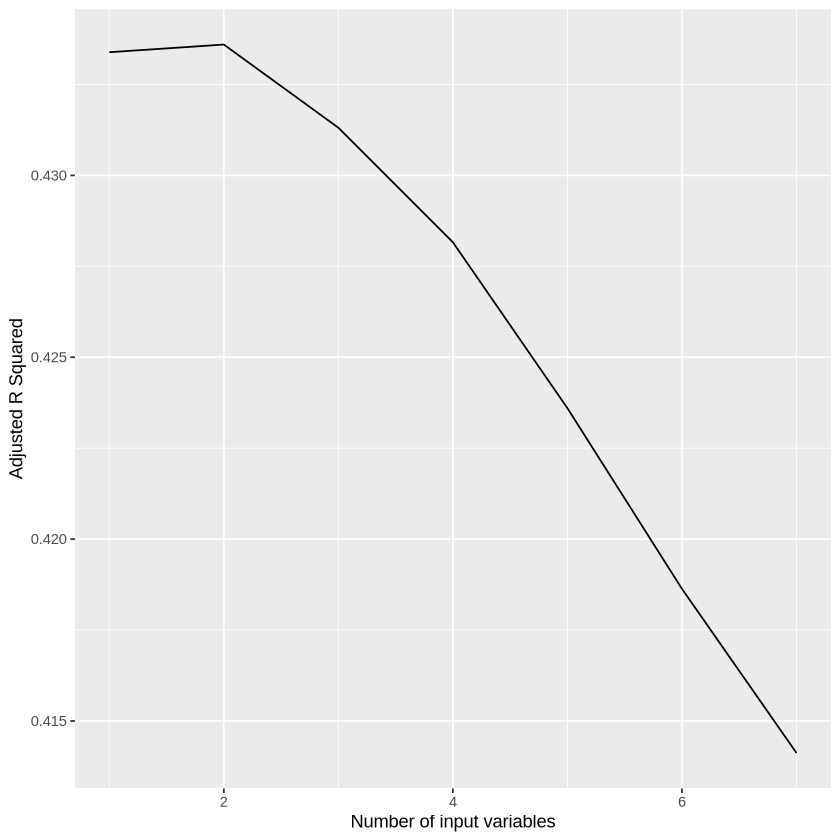

In [72]:
tips_fwd_summary_df <- 
    tibble(
        n_input_variables = 1:7,
        RSQ = tips_forward_summary$rsq,
        RSS = tips_forward_summary$rss,
        ADJ.R2 = tips_forward_summary$adjr2
    )
tips_fwd_summary_df
ggplot(tips_fwd_summary_df,aes(x =  n_input_variables,y = ADJ.R2)) +
geom_line() + 
labs(x = "Number of input variables",
     y = "Adjusted R Squared",)

In [76]:
tips_linear_model <- lm(tip ~ total_bill + day, tips_test)

In [77]:
anova(lm(tip ~ 1, tips_test),tips_linear_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,121,200.3489,NA,NA,NA,NA
2,117,101.2901,4,99.05881,28.60566,1.403312e-16


In [79]:
anova(tips_linear_model, lm(tip ~ ., tips_test))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,117,101.29010,NA,NA,NA,NA
2,112,95.11845,5,6.171645,1.453397,0.2108441


In [80]:
vif(tips_linear_model)

,GVIF,Df,GVIF^(1/(2*Df))
total_bill,1.045245,1,1.022372
day,1.045245,3,1.007402


In [81]:
tidy(tips_linear_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.075284875,0.315682807,3.40621932,9.034512e-04
total_bill,0.097020404,0.009444827,10.27233216,4.927976e-18
daySat,-0.195920466,0.304844433,-0.64268999,5.216827e-01
daySun,0.009435227,0.295421301,0.03193821,9.745757e-01
dayThur,0.012978053,0.306023929,0.04240862,9.662452e-01
